# Jupyter notebook for VAERS case study for UMC:

**Analyse the drug side-effect reports (def:_narratives_)**

- look at differences between COVID and non-COVID cases
- what can we say about the text?
- suggestions in assignment:
    - first person? why?
    - redundant narrative? why?
- self investigations
    - text lengths and distributions wrt cases -- classifier. Histogram as feature for a Naive Bayes
        - Statistics
    - What features make it first person?
        - Statistics
    - redundancy detection:
        - duplication detection regexp within narrative
        - duplication of information from other columns and data files?
        - fluff content vs. entropy content
    - vocabulary differences: word frequency distributions TF-IDF 
    - content itself: keywords?
    - timing of narrative wrt symptoms?
    - look at all possibilities and their relevant narratives: FN, FP, TP, TN
    - *Sentiment analysis:* TextBlob, Vader, LLM?
    - *Topic models with LDA*


In [1]:
import pickle
import pandas as pd
pd.set_option('display.max_colwidth', None)
from IPython.display import display
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

data_filename = "2020VAERSDATA"
vax_filename = "2020VAERSVAX"
symptoms_filename = "2020VAERSSYMPTOMS"

Read in data and display relevant columns 

In [2]:
# Flag if you want to process all the data, else read from saved files to save time
CREATEFLAG = False
# Flag for: Read big data or sample
read_full_data_FLAG = False
# ---
if read_full_data_FLAG:
    with open(data_filename+".pickle", 'rb') as fh:
        df_data, cols_data = pickle.load(fh)
        display(df_data[cols_data].head(5))
    print("\n\n")
    with open(vax_filename+".pickle", 'rb') as fh:
        df_vax, cols_vax = pickle.load(fh)
        display(df_vax[cols_vax].head(5))
    print("\n\n")
    with open(symptoms_filename+".pickle", 'rb') as fh:
        df_symptoms, cols_symptoms = pickle.load(fh)
        display(df_symptoms[cols_symptoms].head(5))
else:
    with open("data_sample.pickle", 'rb') as fh:
        df_data, df_vax, df_symptoms = pickle.load(fh)
        cols_data = ["VAERS_ID"]
        cols_vax = ["VAERS_ID","VAX_NAME"]

Verify the total number of patient entries:

In [3]:
# Data Check
print(df_data[cols_data[0]].shape)
print(df_vax[cols_data[0]].shape)
print(df_symptoms[cols_data[0]].shape)

print(df_data[cols_data[0]].nunique())
print(df_vax[cols_data[0]].nunique())
print(df_symptoms[cols_data[0]].nunique())

print(set(df_data["VAERS_ID"]).symmetric_difference(set(df_vax["VAERS_ID"])))
print(set(df_data["VAERS_ID"]).symmetric_difference(set(df_symptoms["VAERS_ID"])))

(287,)
(320,)
(346,)
287
287
287
set()
set()


## [0] Data Massaging

In [4]:
# Merge two dataframes into one
# Label as covid and other vaccines

def merge_on_vaers_id(dfa, dfb):
    return pd.merge(dfa, dfb, on="VAERS_ID", how="inner")
    
# Merge VAX and DATA dataframes
if CREATEFLAG:
    # Merge dataframes
    df_vaers = merge_on_vaers_id(df_data, df_vax)
    # covid labelling
    query_keys = ["covid", "cov"]
    mask = df_vaers["VAX_NAME"].str.replace(" ", "").str.contains('|'.join(query_keys), case=False, regex=True)
    df_vaers["VAX_covid"] = "covid_vax"
    df_vaers["VAX_covid"].loc[~mask] = "other_vax"
    print(df_vaers.shape)
    with open("2020_merged_data_all.pickle", "wb") as fh:
        pickle.dump(df_vaers, fh)
else:
    with open("2020_merged_data_all.pickle", 'rb') as fh:
        df_vaers = pickle.load(fh)
        print(df_vaers.shape)


(320, 43)


In [5]:
# def label_vax(row):
#     if row["VAX_NAME"].str.replace(" ", "").str.contains('|'.join(query_keys), case=False, regex=True):
#         return "covid_vax"
#     else:
#         return "other_vax"


# df_vaers["VAX_covid"] = "foo"
# df_vaers["VAX_covid"] = df_vaers["VAX_NAME"].apply(lambda x: label_vax(x))
display(df_vaers.columns)

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'VAX_covid'],
      dtype='object')

## [1] Character count

In [6]:
def char_count(text):
    return len(str(text))

In [7]:
df_vaers["SYMP_len"] = 0
df_vaers["SYMP_len"] = df_vaers["SYMPTOM_TEXT"].apply(lambda x: char_count(x))

display(df_vaers[["SYMP_len", "SYMPTOM_TEXT"]])

,SYMP_len,SYMPTOM_TEXT
0,103,Adverse events: Hives Treatment: Ice and Oral Benadryl Outcome: Minimal Hives in localized area
1,36,"Edema, erythema, pain, firm to touch"
2,110,Patient experienced mild numbness traveling from injection site up and down arm that subsided over 20 minutes.
3,25,Heplisav given to newborn
4,33,Newborn patient received Heplisav
...,...,...
315,2347,"pneumonia; flu; was given the high dose; Initial information was received on 12-Dec-2020 regarding an unsolicited valid serious social media case received from a consumer (Patient). This case involved a 60 year old patient who developed pneumonia, flu (Influenza) and for whom was given the high dose (Extra dose administered) was reported, while patient received INFLUENZA VACCINE. The patient's medical history, medical treatment(s), vaccination(s) and family history were not provided. On an unknown date, the patient received a dose of suspect INFLUENZA VACCINE produced by unknown manufacturer lot number and expiration date not reported via unknown route at unknown administration site for prophylactic vaccination. On an unknown date, the patient developed pneumonia, flu (Influenza), 2 days following the administration of INFLUENZA VACCINE. Seriousness criteria was assessed as hospitalization (caused or prolonged) for events flu and pneumonia. It was also the case of actual medication error due to extra dose administered. Patient reported that had trouble with lungs. No relevant laboratory data was reported. It was not reported if the patient received any corrective treatment. The event outcome was unknown for pneumonia and flu at the time of reporting. There will be no information available on the batch number for this case. This suspected adverse reaction report is submitted and classified as a medication error solely and exclusively to ensure the marketing authorization holder's compliance with the requirements set out in Directive 2001/83/EC and Module VI of the Good Pharmacovigilance Disclaimer: Practices. The classification as a medical error is in no way intended, nor should it be interpreted or construed as an allegation or claim made by the marketing authorization holder that any third party has contributed to or is to be held liable for the occurrence of this medication error.; Sender's Comments: This case concerns an 60 year old patient who developed pneumonia, flu and was given the high dose was reported after vaccination with INFLUENZA VACCINE. It was unknown if the time to onset is compatible. Howerver, concomitant medications, patient's medical condition and laboratory tests ruling out alternate etiologies. Based upon the reported information, the role of vaccine cannot be assessed."
316,252,the patient came in for her second dose and described swelling at the site of injection that lasted for 2 weeks. it was red and hot to the touch and painful. she also had flu-like symptom including a low grade fever and fatigue that lasted for 2 days
317,74,12/15/2020 5:00 PM Nauseas(worst ) 5:30 Pm Headache 6:00 Pm Stomach Pain
318,230,"PAIN AND EDEMA AT SITE OF INJECTION LEFT ARM WITH DECREASED RANGE OF MOTION LEFT ARM RIB CAGE PAIN ON INSPIRATION MUSCLE PAIN RIGHT AND LEFT THIGHS, WORSENING UPON AMBULATION MUSCLE PAIN AND TINGLING RIGHT UPPER EXTREMITY AND BACK"


## [2] POV Analysis

In [8]:
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()
# Load spaCy pipeline (model)
nlp = spacy.load('en_core_web_sm')

In [9]:
def pov_detect(txt):
    # process into tokens
    nlp = English()
    tknzr = nlp.tokenizer
    tokens = tknzr(txt)
    token_list = [a.text for a in list(tokens)]
    # compare for first person
    first_person_prons = ["I", "me", "my", "mine", "we", "us", "our", "ours"]
    # check and return
    if any(prons in token_list for prons in first_person_prons):
        return "1_person"
    else:
        return "23_person"

In [10]:
if CREATEFLAG:
    # Do point of view analysis
    df_vaers["SYMP_pov"] = ''
    df_vaers["SYMP_pov"] = df_vaers["SYMPTOM_TEXT"].apply(lambda x: pov_detect(str(x)))
    display(df_vaers.columns)
    
    with open("vaers_data_2_pov.pickle", "wb") as fh:
        pickle.dump(df_vaers, fh)
else:
    with open("vaers_data_2_pov.pickle", "rb") as fh:
        df_vaers = pickle.load(fh)

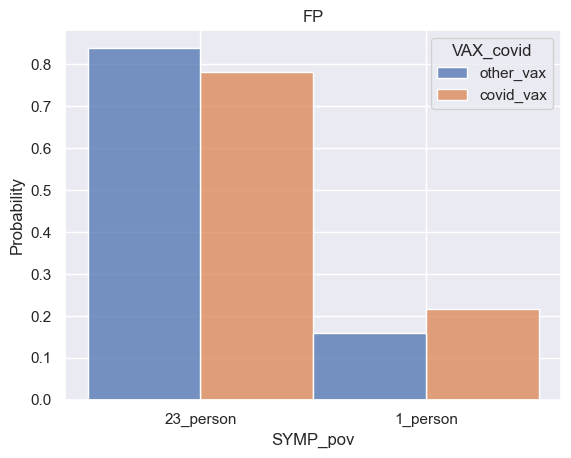

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.figure
sns.histplot(data=df_vaers, x="SYMP_pov", hue="VAX_covid", \
             stat="probability", \
             common_norm=False, multiple="dodge").set_title("FP")
plt.show()

## [3] Redundancy Analysis -- See slides

- Tried preliminarily with *[MoreThanSentiments](https://towardsdatascience.com/morethansentiments-a-python-library-for-text-quantification-e57ff9d51cd5)* package
- Had some promising results of redundancy through *Boilerplate Analysis*

## [4] Active and Passive Voice Analysis

 Parts of speech: [link](https://universaldependencies.org/docs/en/dep/)

In [12]:
from spacy.matcher import Matcher

# Create pattern to match passive voice use
passive_rules = [
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'VBN'}],
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'VBZ'}],
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'RB'}, {'TAG': 'VBN'}],
]
# Create pattern to match active voice use
active_rules = [
    [{'DEP': 'nsubj'}, {'TAG': 'VBD', 'DEP': 'ROOT'}],
    [{'DEP': 'nsubj'}, {'TAG': 'VBP'}, {'TAG': 'VBG', 'OP': '!'}],
    [{'DEP': 'nsubj'}, {'DEP': 'aux', 'OP': '*'}, {'TAG': 'VB'}],
    [{'DEP': 'nsubj'}, {'DEP': 'aux', 'OP': '*'}, {'TAG': 'VBG'}],
    [{'DEP': 'nsubj'}, {'TAG': 'RB', 'OP': '*'}, {'TAG': 'VBG'}],
    [{'DEP': 'nsubj'}, {'TAG': 'RB', 'OP': '*'}, {'TAG': 'VBZ'}],
    [{'DEP': 'nsubj'}, {'TAG': 'RB', 'OP': '+'}, {'TAG': 'VBD'}],
]

# create a matcher
matcher = Matcher(nlp.vocab)  # Init. the matcher with a vocab (note matcher vocab must share same vocab with docs)
matcher.add('Passive',  passive_rules)  # Add passive rules to matcher
matcher.add('Active', active_rules)  # Add active rules to matcher

In [13]:
# Function to check Active or Passive Voice
def voice_tally(symptom_text):
    sentences = symptom_text.split('.')
    num_sentences = len(sentences)
    actives = 0
    passives = 0
    neither = 0
    for s in sentences:
        doc = nlp(s)  # Process text with spaCy model
        matches = matcher(doc)  # Get matches
        # print("-"*40 + "\n" + s)
        if len(matches) > 0:
            for match_id, start, end in matches:
                string_id = nlp.vocab.strings[match_id]
                span = doc[start:end]  # the matched span
                # print("\t{}: {}".format(string_id, span.text))
                if string_id == "Active":
                    actives += 1
                elif string_id == "Passive":
                    passives += 1
        else:
            # print("\tNo active or passive voice detected.")
            neither += 1
    total_detections = float(actives+passives+neither)
    return [np.round(actives/total_detections, 2), np.round(passives/total_detections, 2), np.round(neither/total_detections, 2), total_detections, num_sentences]

In [14]:
if CREATEFLAG:
    # Do Active Passive Analysis on Symptom_Text
    df_vaers["SYMP_tenses"] = df_vaers["SYMPTOM_TEXT"].apply(lambda x: voice_tally(x))
    display(df_vaers[["SYMP_tenses", "SYMP_len", "SYMPTOM_TEXT"]])
    
    df_vaers[["SYMP_active","SYMP_passive","SYMP_neither","SYMP_detections","SYMP_sentences"]] = \
    df_vaers["SYMP_tenses"].tolist()
    
    with open("vaers_data_3_pov.pickle", "wb") as fh:
        pickle.dump(df_vaers, fh)
else:
    with open("vaers_data_3_pov.pickle", "rb") as fh:
        df_vaers = pickle.load(fh)

        

In [15]:
def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)

    return round(np.sum(np.where(p * q >= 0.000001, p * np.log(p / q), 0)), 4)

In [16]:
# Need to make a truncated dataframe for Seaborn
disp_df = df_vaers[["SYMP_active","SYMP_passive","SYMP_neither","VAX_covid"]]

#### CASE: Active Voice

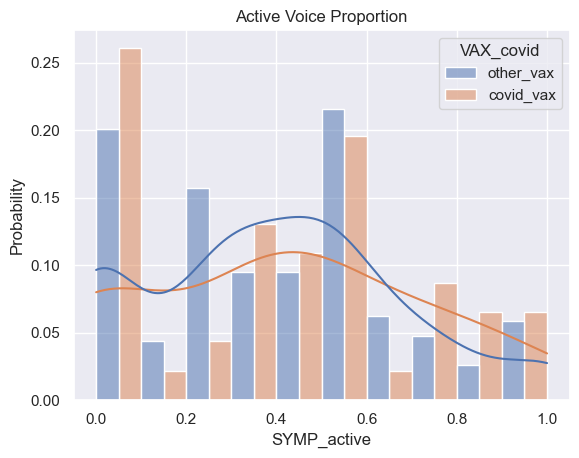

0.1331
0.163


In [17]:
# Visualise
plt.figure
sns.histplot(data=disp_df, x="SYMP_active", hue="VAX_covid", \
             stat="probability", \
             common_norm=False,\
            multiple="dodge", \
            kde=True).set_title("Active Voice Proportion")

plt.show()

# Histogram values
pmf_active_covid, b_edges = np.histogram(disp_df.loc[disp_df["VAX_covid"]=="covid_vax"]["SYMP_active"], density=False)
pmf_active_covid = pmf_active_covid/ float(np.sum(pmf_active_covid))
# print(pmf_active_covid)

pmf_active_other, b_edges = np.histogram(disp_df.loc[disp_df["VAX_covid"]=="other_vax"]["SYMP_active"], density=False)
pmf_active_other = pmf_active_other/ float(np.sum(pmf_active_other))
# print(pmf_active_other)

print(kl(pmf_active_covid, pmf_active_other))
print(kl(pmf_active_other, pmf_active_covid))

#### CASE: Passive Voice

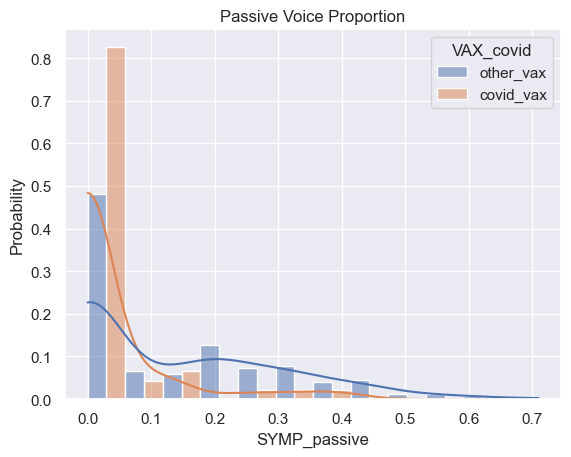

[0.82608696 0.02173913 0.02173913 0.06521739 0.         0.
 0.02173913 0.         0.02173913 0.02173913]
[0.50729927 0.06934307 0.14233577 0.08029197 0.08394161 0.04744526
 0.03649635 0.01824818 0.01094891 0.00364964]
0.3656
0.1221


In [18]:
# Histogram and distributions
plt.figure
sns.histplot(data=disp_df, x="SYMP_passive", hue="VAX_covid", \
             stat="probability", \
             common_norm=False,\
            multiple="dodge", \
            kde=True).set_title("Passive Voice Proportion")

plt.show()

# Histogram values
pmf_passive_covid, b_edges = np.histogram(disp_df.loc[disp_df["VAX_covid"]=="covid_vax"]["SYMP_passive"], density=False)
pmf_passive_covid = pmf_passive_covid/ float(np.sum(pmf_passive_covid))
print(pmf_passive_covid)

pmf_passive_other, b_edges = np.histogram(disp_df.loc[disp_df["VAX_covid"]=="other_vax"]["SYMP_passive"], density=False)
pmf_passive_other = pmf_passive_other/ float(np.sum(pmf_passive_other))
print(pmf_passive_other)

print(kl(pmf_passive_covid, pmf_passive_other))
print(kl(pmf_passive_other, pmf_passive_covid))

#### CASE: Neither Voice

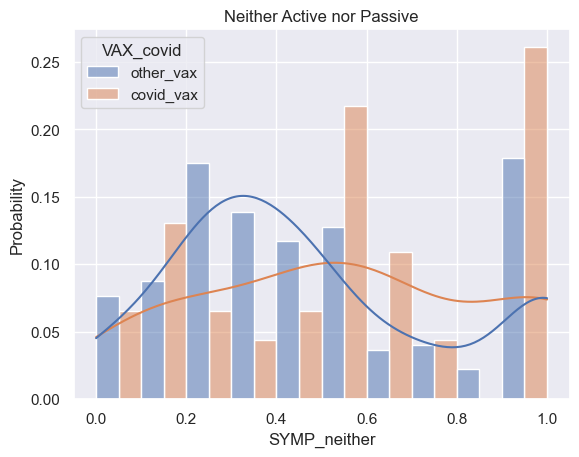

[0.06521739 0.13043478 0.06521739 0.04347826 0.06521739 0.2173913
 0.10869565 0.04347826 0.         0.26086957]
[0.07664234 0.08759124 0.17518248 0.13868613 0.11678832 0.12773723
 0.03649635 0.04014599 0.02189781 0.17883212]
0.2247
0.201


In [19]:
plt.figure
sns.histplot(data=disp_df, x="SYMP_neither", hue="VAX_covid", \
             stat="probability", \
             common_norm=False,\
            multiple="dodge", \
            kde=True).set_title("Neither Active nor Passive")

plt.show()

# Histogram values
pmf_neither_covid, b_edges = np.histogram(disp_df.loc[disp_df["VAX_covid"]=="covid_vax"]["SYMP_neither"], density=False)
pmf_neither_covid = pmf_neither_covid/ float(np.sum(pmf_neither_covid))
print(pmf_neither_covid)

pmf_neither_other, b_edges = np.histogram(disp_df.loc[disp_df["VAX_covid"]=="other_vax"]["SYMP_neither"], density=False)
pmf_neither_other = pmf_neither_other/ float(np.sum(pmf_neither_other))
print(pmf_neither_other)

print(kl(pmf_neither_covid, pmf_neither_other))
print(kl(pmf_neither_other, pmf_neither_covid))